In [1]:
import lightkurve as lk
import pandas
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.table import Table, Column
import lightkurve
import emcee
from lightkurve.lightcurve import LightCurve
import os
import batman

In [138]:
def BATMAN(t0,
           P = 18.79318,
           t = None,
           baseline = 1.0):
            
    params = batman.TransitParams()
    params.t0 = t0                       # time of inferior conjunction ()
    params.per = P                       # period in days
    params.rp = 0.047                       # planet radius (in units of stellar radii)
    params.a = 57.                         # semi-major axis (in units of stellar radii)
    params.inc = 89.13                     # orbital inclination (in degrees)
    params.ecc = 0.                      # eccentricity
    params.w = 90.                       # longitude of periastron (in degrees)
    params.u = [0.4,0.4]                        # limb darkening coefficients [u1, u2]
    params.limb_dark = "quadratic"       # limb darkening model
        
    #m = batman.TransitModel(params, t, exp_time=60.0, supersample_factor = 12)   # initializes model
    m = batman.TransitModel(params, t)   # initializes model
    
    flux = m.light_curve(params)*baseline   # calculates light curve
    
    return flux

In [139]:
os.chdir('/Users/willwaalkes/Desktop/PhD_Thesis/TFOP/Transit_Analysis/')

TOI = 2094.01

In [140]:
APO_Data = pandas.read_csv('Data/measurements/TIC356016119-01_20210601_APO_ip_measurements.csv')

McDonald_Data = pandas.read_table('Data/measurements/TIC356016119-01_20210621_LCO-McD-1m0_ip_15px_measurements.tbl',
                                  comment='#', delim_whitespace=True)

In [152]:
apo_time = APO_Data['BJD_TDB']
flux = APO_Data['rel_flux_T1']
apo_flux = flux/np.median(flux)
err = APO_Data['rel_flux_err_T1']
apo_err = err/np.median(flux)

lco_time = McDonald_Data['BJD_TDB']
flux = McDonald_Data['rel_flux_T1']
lco_flux = flux/np.median(flux[0:50])-0.001
err = McDonald_Data['rel_flux_err_T1']
lco_err = err/np.median(flux[0:50])

<ErrorbarContainer object of 3 artists>

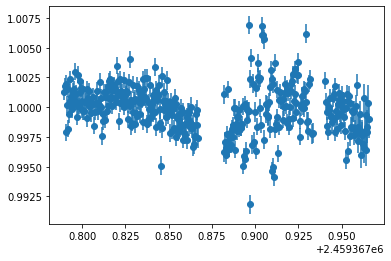

In [153]:
plt.errorbar(apo_time,apo_flux,yerr=apo_err,fmt='o')

(0.99, 1.008)

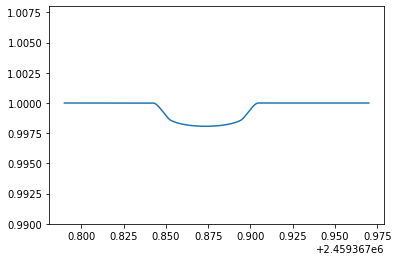

In [154]:
apo_t = np.linspace(2459367.79,2459367.97,10000)
apo_model = BATMAN(t0=2459367.873577,t=apo_t)

plt.plot(apo_t,apo_model)
plt.ylim(0.99,1.008)

<ErrorbarContainer object of 3 artists>

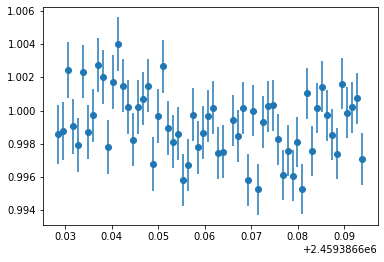

In [155]:
plt.errorbar(lco_time,lco_flux,yerr=lco_err,fmt='o')

(0.994, 1.007)

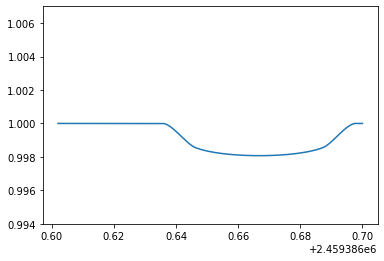

In [156]:
lco_t = np.linspace(2459386.602,2459386.7,10000)
lco_model = BATMAN(t0=(2459367.873577+18.79318),t=lco_t)

plt.plot(lco_t,lco_model)
plt.ylim(0.994,1.007)

In [157]:
params = pandas.read_csv('Data/TESS_Objects.csv',comment='#')

TIC_IDs = params['TIC_ID']
TOIs = params['TOI']

for i in range(len(TOIs)):
    if TOIs[i] == TOI:
        index = i

tic_id = int(TIC_IDs[index])
toi = TOIs[index]
observatory = 'TESS'

print('TIC ',tic_id)
print('TOI ',toi)

TIC  356016119
TOI  2094.01


In [158]:
#lcf = lk.search_lightcurvefile(f'TIC {tic_id}').download_all()
#lcf

In [159]:
#stitched_lc = lcf.PDCSAP_FLUX.stitch().remove_outliers(sigma=10)
#stitched_lc.scatter(alpha=0.2,color='royalblue',rasterized=True)

In [160]:
planet_period = params['P (days)'][index] # must be in days
planet_radius = params['Rp/R*'][index] # Rp/R*
Epoch = params['Epoch'][index] 
planet_a = params['a/R*'][index] # a/R*
planet_b = params['b'][index] # impact parameter
planet_duration = params['Dur'][index] #hours
ppm_depth = params['Depth'][index] #ppm

planet_i = np.arccos(planet_b/planet_a)*180/np.pi #inclination in degrees
depth = (1-ppm_depth/1e6)

star_teff = params['T_eff'][index] # K
star_met = params['Met'][index] # metallicity
star_g = params['logg'][index] # log g
star_radius = params['R_s'][index] #R*/Rsun

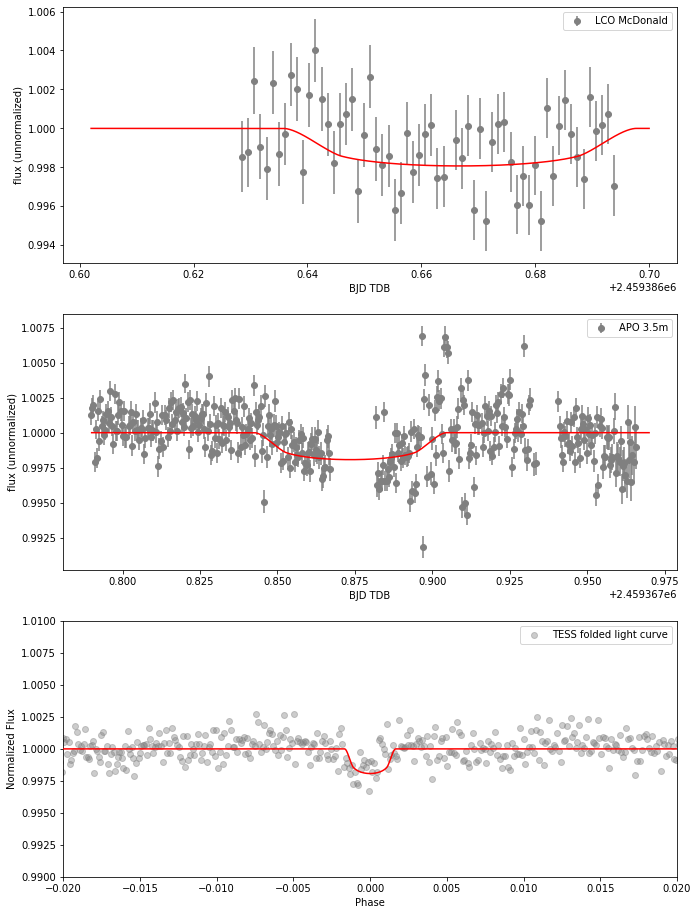

In [162]:
# This box will plot the full folded light curve as well as a zoomed in region on the transit

folded_lc = stitched_lc.fold(period=18.79318, t0=Epoch)

TLC = folded_lc

fig, (ax0,ax1,ax2) = plt.subplots(3,1,figsize=(11,16))

TESS_model = BATMAN(t0 = 0, t = tess_t,P=1)

#ingress = (Epoch+n*planet_period)-(planet_duration/2)/24
ingress = (0-(planet_duration/2)/24)/planet_period
#egress = (Epoch+n*planet_period)+(planet_duration/2)/24
egress = (0+(planet_duration/2)/24)/planet_period

ax0.errorbar(lco_time,lco_flux,yerr=lco_err,fmt='o',label='LCO McDonald',color='gray')
ax0.plot(lco_t,lco_model,color='r',zorder=100)
ax0.set_xlabel('BJD TDB')
ax0.set_ylabel('flux (unnormalized)')
ax0.legend()

ax1.errorbar(apo_time,apo_flux,yerr=apo_err,fmt='o',label='APO 3.5m',color='gray')
ax1.plot(apo_t,apo_model,zorder=100,color='r')
ax1.set_xlabel('BJD TDB')
ax1.set_ylabel('flux (unnormalized)')
ax1.legend()

ax2.scatter(TLC.bin(binsize=20).time, TLC.bin(binsize=20).flux,
            alpha=0.4,rasterized=True,label='TESS folded light curve',color='gray')
ax2.plot(tess_t,TESS_model,color='r',zorder=100)
ax2.set_xlim(ingress-0.02, egress+0.02)
ax2.set_ylim(0.99,1.01)
ax2.set_xlim(-0.02,0.02)
ax2.set_ylabel('Normalized Flux')
ax2.set_xlabel('Phase')
ax2.legend()

plt.savefig('TOI_2094_multiobs')
plt.show()